In [55]:
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [56]:
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


In [57]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

In [58]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [59]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [60]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [61]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


In [62]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    #X = np.array(X)    
    #y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

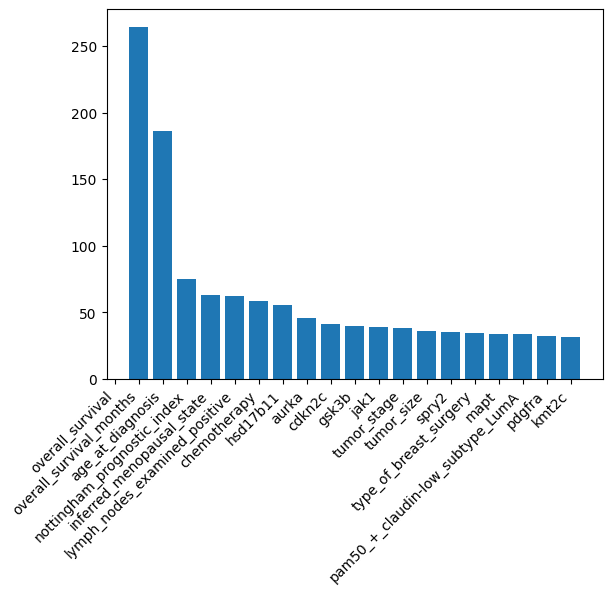

In [63]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [64]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


## Perform Bayesian Optimization

In [110]:
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=20, activation=activation))
        nn.add(Dropout(0.9))
        nn.add(Dense(1, activation='softplus'))
        nn.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_squared_logarithmic_error'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [111]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [112]:
# Set paramaters
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
| 1         | 0.4287    | 5.51      | 335.3     | 54.88     | 0.7716    | 36.58     | 1.044     |
| 2         | 0.4287    | 0.2023    | 536.2     | 39.09     | 0.3443    | 99.16     | 1.664     |
| 3         | 0.4287    | 0.7307    | 735.7     | 69.7      | 0.2815    | 51.96     | 0.8286    |
| 4         | 0.4287    | 0.6656    | 920.6     | 83.52     | 0.8422    | 83.37     | 6.937     |
| 5         | 0.4287    | 5.195     | 851.0     | 53.71     | 0.03717   | 50.87     | 0.7373    |
| 6         | 0.4287    | 7.355     | 758.2     | 65.22     | 0.2815    | 99.86     | 0.9663    |
| 7         | 0.4287    | 5.539     | 588.0     | 52.4      | 0.7306    | 39.05     | 2.804     |
| 8         | 0.4287    | 2.871     | 957.8     | 93.5      | 0.8157    | 13.07     | 6.604     |
| 9         | 0.4287

In [113]:
params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

{'activation': 'elu',
 'batch_size': 335.25580347650913,
 'epochs': 54.884721549693616,
 'learning_rate': 0.7715698477978916,
 'neurons': 36.57927739625886,
 'optimizer': 1.0441406999764284}

In [103]:
optimizer = keras.optimizers.Adam(learning_rate=0.7715698477978916)
nn = keras.Sequential([    
    keras.layers.Dense(37, input_shape = (20, ), activation = 'elu'),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(1, activation='softplus')  
])

nn.compile(optimizer = optimizer,
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [104]:
nn_fit = nn.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=55, batch_size=335)

Epoch 1/55
5/5 [==============================] - 1s 40ms/step - loss: 5.1609 - mse: 8840.7695 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 2/55
5/5 [==============================] - 0s 11ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 3/55
5/5 [==============================] - 0s 13ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 4/55
5/5 [==============================] - 0s 13ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 5/55
5/5 [==============================] - 0s 14ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 6/55
5/5 [==============================] - 0s 13ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 7/55
5/5 [==============================] - 0s 12ms/step - loss: 0.5043 - mse: 1.5205 - val_loss: 0.5533 - val_mse: 1.6907
Epoch 8/55
5/5 [==============================] - 0s 12ms/step - loss: 0.5043 - mse: 1.5205 - 

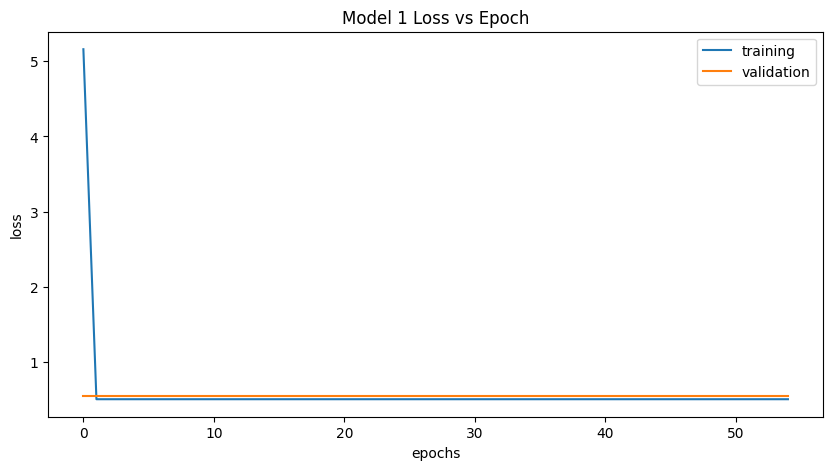

In [105]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(nn_fit.history['loss'], label = 'training')
plt.plot(nn_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model 1 Loss vs Epoch')
plt.legend()

In [106]:
predictions=(nn.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 2ms/step


In [107]:
predictions

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

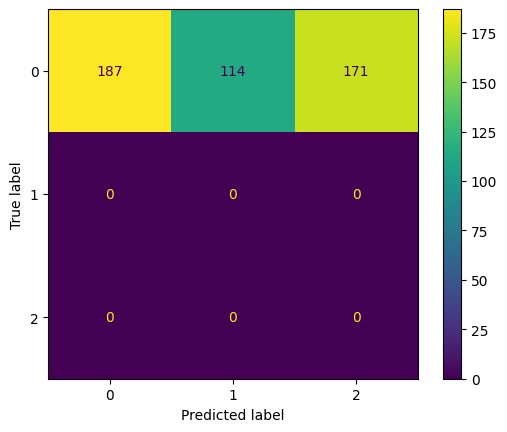

In [109]:
cm = confusion_matrix(predictions,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [100]:
y_test

991     0.0
977     0.0
1542    1.0
1768    0.0
244     1.0
       ... 
1891    1.0
1587    2.0
109     0.0
424     0.0
191     0.0
Name: death_from_cancer, Length: 472, dtype: float64

## Bayesian Optimization the layers.

In [34]:
# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=20, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score


In [35]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4223    | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.298     | 1.045     | 0.426     | 31.48     | 0.3377    | 6.935     |
| 2         | 0.4223    | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 1.932     | 1.237     | 0.08322   | 91.07     | 0.794     | 5.884     |
| 3         | 0.4223    | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.055     | 1.908     | 0.1143    | 83.55     | 0.6977    | 3.957     |
| 4         | 0.4223    | 2.468     | 998.8     | 0.138     | 0.1846    | 58.8      | 1.81      | 2.456     | 0.3296    | 46.05     | 0.319     | 6.631     |
| 5         | 0.4223    | 8.268     | 851.1     | 0.

In [36]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'elu',
 'batch_size': 335,
 'dropout': 0.4360590193711702,
 'dropout_rate': 0.23077874175693686,
 'epochs': 44,
 'layers1': 1,
 'layers2': 1,
 'learning_rate': 0.42602224734191213,
 'neurons': 31,
 'normalization': 0.33765619188879237,
 'optimizer': <keras.optimizers.optimizer_v2.ftrl.Ftrl at 0x7ff2646557e0>}

In [54]:
# Fitting Neural Network
nn = keras.Sequential([    
    keras.layers.Dense(31, input_shape = (20, ), activation = 'elu'),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4360590193711702),
    keras.layers.Dense(1, activation='elu'),
    keras.layers.Dropout(0.23077874175693686),
])

In [51]:
nn

<function __main__.nn_cl_fun()>

In [52]:
nn.fit(X_train,y_train)

AttributeError: 'function' object has no attribute 'fit'

In [49]:
nn

KerasClassifier(
	model=None
	build_fn=<function nn_cl_fun at 0x7ff26600aa70>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=335
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=44
	class_weight=None
)